Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cluster 0: [30000]
Cluster 1: [15000 70000 25000 22000 55000]
Cluster 2: [40000]
Cluster 3: [95000]
Cluster 4: [18000]
Validation RMSE: 10600.9905
Validation R2: -8.1740
Validation RMSE: 6010.0735
Validation R2: -0.0034
Validation RMSE: 6327.6640
Validation R2: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Validation RMSE: 51513.1399
Validation R2: nan
Validation RMSE: 36322.6255
Validation R2: nan
Test Set RMSE: 55846.5188
Test Set R2: -3.1241


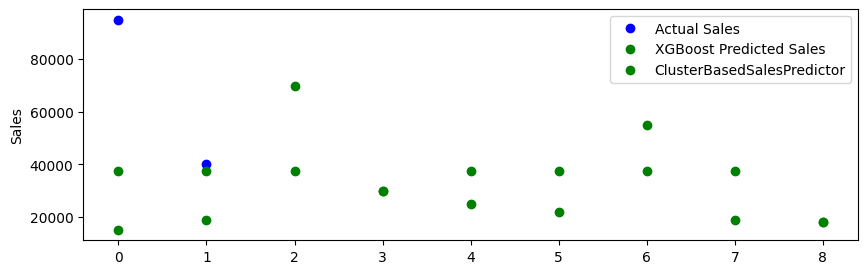

Predicted sales saved to /content/drive/MyDrive/paper modeling/11.recomm/data/MachinL결과.xlsx


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import xgboost as xgb
import matplotlib.pyplot as plt
from google.colab import drive

################################################################################
# KMeans 기반 클러스터 평균 매출을 예측
###############################################################################
class ClusterBasedSalesPredictor:
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.scaler = StandardScaler()

    def fit(self, features, sales):
        """Q
        Fit the clustering model using input features and associated sales data.
        """
        # 특징스케일링 : 기존상품명, 평점 combineQ
        features_scaled = self.scaler.fit_transform(features)
        # 특징을 KMeans클러스터링 학습 (데이터를 클러스터로만듬)
        self.kmeans.fit(features_scaled)
        # 각클라스터의 매출평균값 (cluster_sales)
        self.cluster_sales = {}
        for cluster in range(self.n_clusters):
            cluster_indices = self.kmeans.labels_ == cluster
            # 예시: sales = np.array([100, 200, 300, 400, 500, 600, 700])
            # labels = np.array([0, 1, 2, 1, 0, 2, 1])      # KMeans가 생성한 클러스터 라벨 (n=3일떄)
            print(f"Cluster {cluster}: {sales[cluster_indices]}")
            ##### 결과: Cluster 0: [100 500] / Cluster 1: [200 400 700] / Cluster 2: [300 600]
            # 각클라스터의 매출평균값 (cluster_sales)
            self.cluster_sales[cluster] = sales[cluster_indices].mean()

    def predict(self, features):
        """
        Predict sales for given features based on cluster averages.
        """
        # 특징스케일링 : 새로운상품명, 평점 combine
        features_scaled = self.scaler.transform(features)
        # 새로운상품특징데이터를 KMeans학습된모델에입력 / 각샘플이속하는 클러스터번호 찾음
        clusters = self.kmeans.predict(features_scaled)
        # 각클러스터의 매출평균값 (cluster_sales)
        predicted_sales = torch.tensor([self.cluster_sales[cluster] for cluster in clusters])

        return predicted_sales


if __name__ == "__main__":
    # Google Drive 만용트
    drive.mount('/content/drive')
    file_path = "/content/drive/MyDrive/paper modeling/11.recomm/data/LLM추천결과.csv"
    data = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')

    # 상품명 및 새로운상품명 텍스트를 벡터화
    vectorizer = TfidfVectorizer()
    text_features = vectorizer.fit_transform(data['구매상품명'].fillna('')).toarray()
    new_text_features = vectorizer.transform(data['상품추천결과'].fillna('')).toarray()
    reviewscore = pd.to_numeric(data['평점'], errors='coerce').fillna(0).values.reshape(-1, 1)
    # features : 기존상품명, 평점 combine
    features = np.hstack((text_features, reviewscore))
    sales = pd.to_numeric(data["매출액"], errors='coerce').fillna(0).values
    num_samples = features.shape[0]     # 샘플수
    n_clusters = min(5, num_samples)    # 클러스터수는 샘플수 이하로 제한 / KMeans 클러스터수를 동적으로 설정

    ######################################################
    # 클러스터모델 학습: feature, sales
    ########################################################
    predictor = ClusterBasedSalesPredictor(n_clusters=n_clusters)
    predictor.fit(features, sales)
    ######################################################
    # 클러스터모델 예측: new_features
    ########################################################
    new_text_features = vectorizer.transform(data['상품추천결과'].fillna('')).toarray()
    new_reviewscore = pd.to_numeric(data['평점'], errors='coerce').fillna(0).values.reshape(-1, 1)
    new_features = np.hstack((new_text_features, new_reviewscore))
    predicted_sales = predictor.predict(new_features)


    ######################################################
    # 머신러닝 예측모델 호출
    ########################################################
    X_train, X_test, Y_train, Y_test = train_test_split(features, sales, test_size=0.2, random_state=42)
    # XGBoost모델선택
    xgb_model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, n_estimators=100, n_jobs=-1)
    # K-Fold Cross-Validation
    # 학습데이터를 5개로나눠서, 첫번째 4개그룹으로 학습(Train), 마지막 1개그룹으로 검증
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(X_train, Y_train):
        x_train, x_val = X_train[train_index], X_train[test_index]
        y_train, y_val = Y_train[train_index], Y_train[test_index]

        xgb_model.fit(x_train, y_train)
        # 검증데이터로 Y값예측
        y_pred = xgb_model.predict(x_val)
        # 검증데이터와 예측데이터 비교
        print('Validation RMSE: {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_val, y_pred))))
        print('Validation R2: {:.4f}'.format(metrics.r2_score(y_val, y_pred)))

    # Final Evaluation on Test Set
    xgb_model.fit(X_train, Y_train)
    ##### 예측저장할값, 원래 X_test인데 엑샐행갯수 맞추기위해 features로 변경하여 예측함
    predictions = xgb_model.predict(features)  #X_test
    predictions1 = xgb_model.predict(X_test)  #X_test
    print("Test Set RMSE: {:.4f}".format(np.sqrt(metrics.mean_squared_error(Y_test, predictions1))))
    print("Test Set R2: {:.4f}".format(metrics.r2_score(Y_test, predictions1)))

    # Visualization
    plt.figure(figsize=(10, 3))
    plt.plot(Y_test[:100], 'bo', label='Actual Sales')
    plt.plot(predictions[:100], 'go', label='XGBoost Predicted Sales')
    plt.plot(predicted_sales[:100], 'ro', label='ClusterBasedSalesPredictor')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


    # 엑셀저장
    data["머신러닝cluster예측매출액"] = predicted_sales.numpy()
    data["XGB_예측매출액"] = predictions
    #data.loc[X_test.index, 'XGB_예측매출액'] = predictions  # 인덱스 직접 사용

    output_path = "/content/drive/MyDrive/paper modeling/11.recomm/data/MachinL결과.xlsx"
    data.to_excel(output_path, index=False)

    print(f"Predicted sales saved to {output_path}")


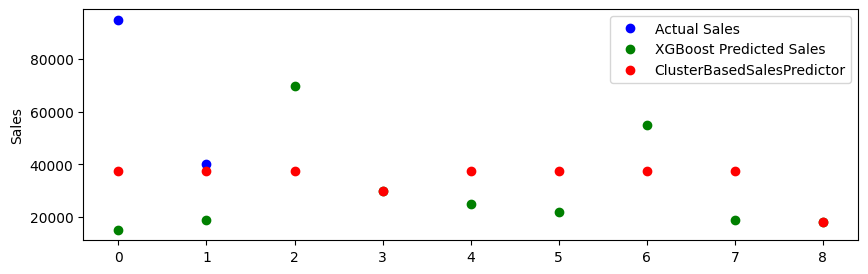

<ipython-input-23-ce4a7ab44425>:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_sales, label='Actual Sales', shade=True, color='blue')
<ipython-input-23-ce4a7ab44425>:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predicted_sales_dl, label='Deep Learning Predicted Sales', shade=True, color='red')
<ipython-input-23-ce4a7ab44425>:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predicted_sales_ml2, label='Machine Learning Predicted Sales', shade=True, color='green')


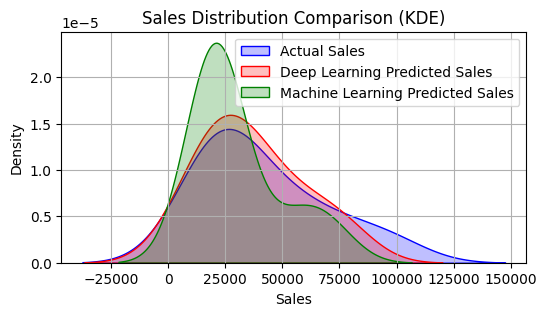

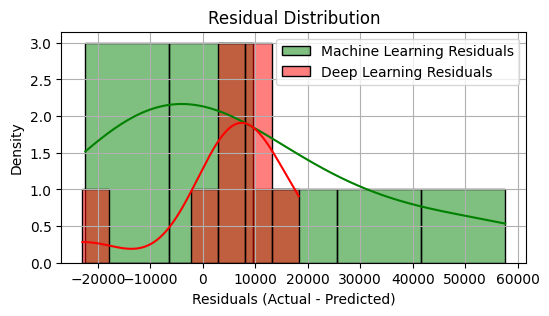

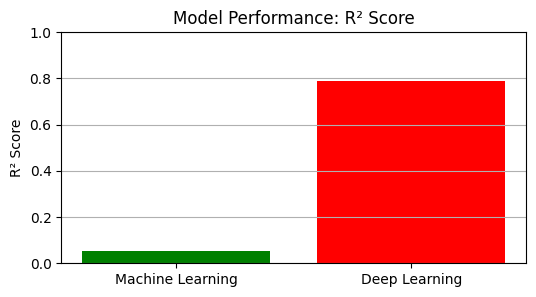

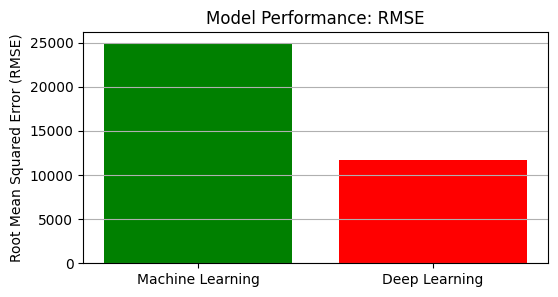

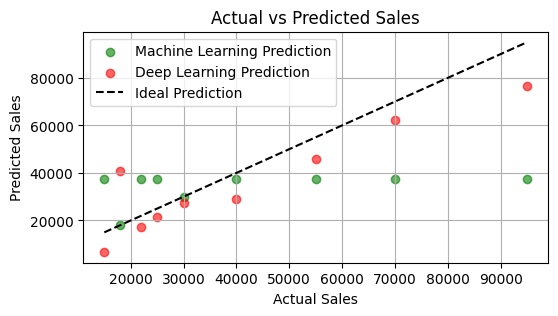

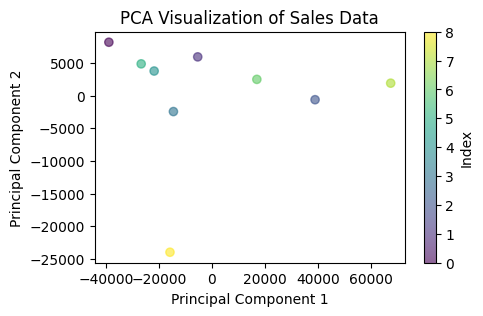

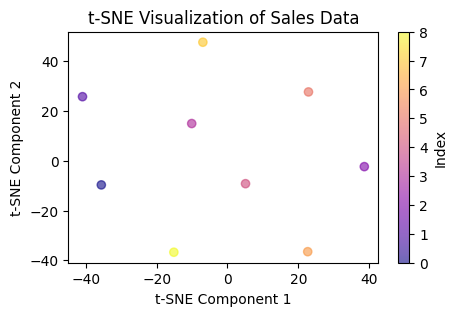

In [23]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Load data from Excel
file_path = "/content/drive/MyDrive/paper modeling/11.recomm/data/DeepL결과.xlsx"
data = pd.read_excel(file_path)

file_path2 = "/content/drive/MyDrive/paper modeling/11.recomm/data/MachinL결과.xlsx"
data2 = pd.read_excel(file_path2)

##################################
# 컬럼을추출해 넘피로 변환
##################################
actual_sales = pd.to_numeric(data['매출액'], errors='coerce').fillna(0).values  # Existing product sales
predicted_sales_dl = pd.to_numeric(data['##예측 매출액'], errors='coerce').fillna(0).values
predicted_sales_ml = pd.to_numeric(data2['머신러닝cluster예측매출액'], errors='coerce').fillna(0).values  # Machine Learning predicted sales
#predicted_sales_ml2 = pd.to_numeric(data2['XGB_예측매출액'], errors='coerce').fillna(0).values  # Machine Learning predicted sales

# Visualization
plt1.figure(figsize=(10, 3))
plt1.plot(Y_test[:100], 'bo', label='Actual Sales')
plt1.plot(predictions[:100], 'go', label='XGBoost Predicted Sales')
plt1.plot(predicted_sales[:100], 'ro', label='ClusterBasedSalesPredictor')
plt1.ylabel('Sales')
plt1.legend()
plt1.show()

# 분포비교 KDE Plot for Distribution Comparison
plt.figure(figsize=(6, 3))
sns.kdeplot(actual_sales, label='Actual Sales', shade=True, color='blue')
sns.kdeplot(predicted_sales_dl, label='Deep Learning Predicted Sales', shade=True, color='red')
sns.kdeplot(predicted_sales_ml2, label='Machine Learning Predicted Sales', shade=True, color='green')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.title('Sales Distribution Comparison (KDE)')
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
plt.figure(figsize=(6, 3))
residuals_ml = actual_sales - predicted_sales_ml
residuals_dl = actual_sales - predicted_sales_dl
sns.histplot(residuals_ml, label='Machine Learning Residuals', kde=True, color='green', alpha=0.5)
sns.histplot(residuals_dl, label='Deep Learning Residuals', kde=True, color='red', alpha=0.5)
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Density')
plt.title('Residual Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Model Performance (R² Score & RMSE)
metrics = {
    "Machine Learning": [r2_score(actual_sales, predicted_sales_ml),
                          np.sqrt(mean_squared_error(actual_sales, predicted_sales_ml))],
    "Deep Learning": [r2_score(actual_sales, predicted_sales_dl),
                       np.sqrt(mean_squared_error(actual_sales, predicted_sales_dl))]
}
labels = list(metrics.keys())
r2_scores = [metrics[k][0] for k in labels]
rmse_values = [metrics[k][1] for k in labels]

# 예측력,1에가까울수록좋음 Bar Chart for R² Score
plt.figure(figsize=(6, 3))
plt.bar(labels, r2_scores, color=['green', 'red'])
plt.ylabel('R² Score')
plt.title('Model Performance: R² Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# 오차표현 Bar Chart for RMSE
plt.figure(figsize=(6, 3))
plt.bar(labels, rmse_values, color=['green', 'red'])
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Model Performance: RMSE')
plt.grid(axis='y')
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6, 3))
plt.scatter(actual_sales, predicted_sales_ml, label='Machine Learning Prediction', alpha=0.6, color='green')
plt.scatter(actual_sales, predicted_sales_dl, label='Deep Learning Prediction', alpha=0.6, color='red')
plt.plot([min(actual_sales), max(actual_sales)], [min(actual_sales), max(actual_sales)], '--', color='black', label='Ideal Prediction')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()

#######################################################
# 넘피로변환된 컬럼을 스택으로쌓음
# PCA 및 t-SNE와 같은 차원 축소 기법에 입력으로 사용
# 매출 데이터를 시각적으로 비교
#######################################################
# Stack data for PCA and t-SNE
all_sales = np.vstack((actual_sales, predicted_sales_dl, predicted_sales_ml)).T

# Create labels for each type of data
labels = ['Actual Sales'] * len(actual_sales) + \
         ['DL Predicted'] * len(predicted_sales_dl) + \
         ['ML Predicted'] * len(predicted_sales_ml)

# PCA
pca = PCA(n_components=2)
sales_pca = pca.fit_transform(all_sales)

plt.figure(figsize=(5, 3))
plt.scatter(sales_pca[:, 0], sales_pca[:, 1], alpha=0.6, c=np.arange(len(sales_pca)), cmap='viridis')
plt.title('PCA Visualization of Sales Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Index')
plt.show()

# 데이터 크기 확인
n_samples = all_sales.shape[0]
perplexity = min(30, n_samples - 1)  # perplexity는 데이터 샘플 수보다 작아야 함


# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
sales_tsne = tsne.fit_transform(all_sales)

# t-SNE 시각화
plt.figure(figsize=(5, 3))
plt.scatter(sales_tsne[:, 0], sales_tsne[:, 1], alpha=0.6, c=np.arange(len(sales_tsne)), cmap='plasma')
plt.title('t-SNE Visualization of Sales Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Index')
plt.show()